In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# This AI is trained on the old training data from 
# the root file PMMA180MeV0mmBPType3_EnoughStatistics.root
model_name = 'model-lsr-old'

shuffle_clusters = False

# load the training data
data = DataModel('../SiFi-CC-neural-network/data-mtx-enough-top-8.npz', 
                 batch_size = 128, validation_percent = .1, test_percent = .2, 
                 weight_compton=1, weight_non_compton=.75)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

ai.weight_type = 1
ai.weight_pos_x = 2.5
ai.weight_pos_y = .5
ai.weight_pos_z = 2
ai.weight_energy = 1
ai.weight_e_cluster = .6
ai.weight_p_cluster = .4

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [3]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[16, 8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0000, limbs_l2=.0000)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [4]:
# compile the ai
ai.compile_model(learning_rate=0.003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 60:
        return .003
    elif epoch < 110:
        return .001
    elif epoch < 140:
        return .0003
    elif epoch < 165:
        return .0001
    elif epoch < 185:
        return .00003
    elif epoch < 195:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

In [5]:
# #LOADING
# ai.load(model_name, optimizer=False)
# ai.compile_model()

In [6]:
#TRAINING

In [7]:
%%time
# balance the training data since there are too many background events
ai.data.balance_training = True

# start the training
ai.train(epochs=200, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

# evaluate the AI on the training set
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

8198/8198 [==============================] - 12s 1ms/step - loss: 4.7823 - e_cluster_loss: 0.0470 - p_cluster_loss: 0.1274 - type_loss: 0.2951 - pos_x_loss: 0.0949 - pos_y_loss: 3.0380 - pos_z_loss: 0.0767 - energy_loss: 2.4985 - e_cluster__cluster_accuracy: 0.9620 - p_cluster__cluster_accuracy: 0.8993 - type__type_accuracy: 0.8794 - type__type_tp_rate: 0.9243

CPU times: user 8h 50min 27s, sys: 6min 19s, total: 8h 56min 46s
Wall time: 8h 58min 18s


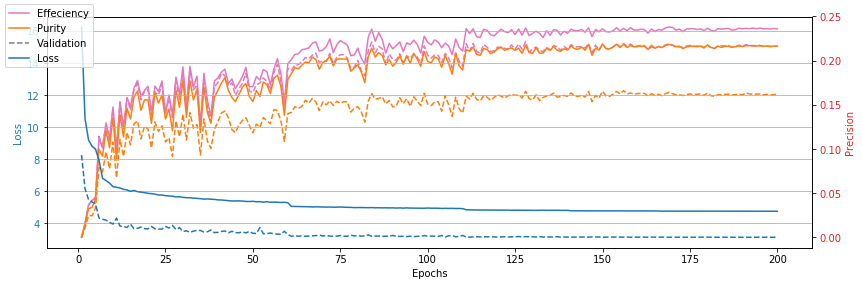

In [8]:
# plot the training loss
ai.plot_training_loss(smooth=False)

In [9]:
# evaluate the AI on the test dataset
ai.evaluate()

AI model
  Loss:        3.04458
    -Type:         0.33529 *  1.00 = 0.33529
    -Pos X:        0.06182 *  2.50 = 0.15455
    -Pos Y:        1.73444 *  0.50 = 0.86722
    -Pos Z:        0.04469 *  2.00 = 0.08938
    -Energy:       1.53363 *  1.00 = 1.53363
    -Cls e:        0.04658 *  0.60 = 0.02795
    -Cls p:        0.09138 *  0.40 = 0.03655
  Accuracy:     0.85689
    -Precision:    0.68483
    -Recall:       0.91735
    -Cls e rate:   0.95138
    -Cls p rate:   0.88517
  Efficiency:   0.21915
  Purity:       0.16360
  Euc mean:    11.40492
  Euc std:     30.31019
  Energy mean:  0.32330
  Energy std:   0.77708

Reco
  Accuracy:     0.64428
    -TP rate:      0.75267
  Efficiency:   0.12909
  Purity:       0.07334
  Euc mean:    21.09294
  Euc std:     49.40878
  Energy mean:  0.54133
  Energy std:   1.10471


In [10]:
# save the trained model
ai.save(file_name=model_name)